In [1]:
import h5py
import numpy as np
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn.functional as F
from torchvision import transforms
import tqdm

In [2]:
# To get the images and labels from file
with h5py.File('../../data/Galaxy10_DECals.h5', 'r') as F:
    images = np.array(F['images'])
    lab = np.array(F['ans'])

# To convert the labels to categorical 10 classes
lab = utils.to_categorical(lab, 10)

# To convert to desirable type
lab = lab.astype(np.float32)
images = images.astype(np.float32)

images.shape, lab.shape

((17736, 256, 256, 3), (17736, 10))

In [3]:
# crop the images to be centered on the galaxy of interest
# NOTE: we tried with 64x64 pixels, but found that the model plateauade around ~78% accuracy beacause it confused dwarf galaxies with bigger galaxies.
# thus, I decided to increase the size of the image to allow the model to learn the difference
ima = images[:, 64:192, 64:192, :]
ima.shape

(17736, 128, 128, 3)

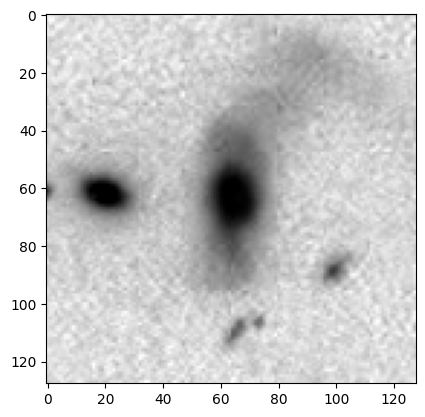

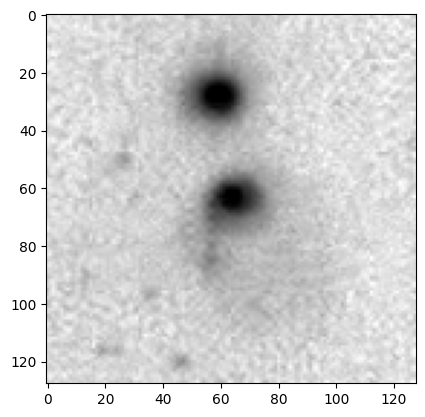

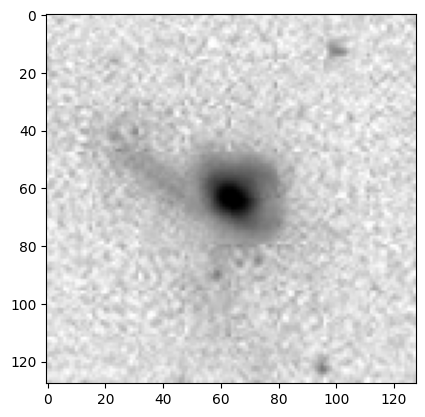

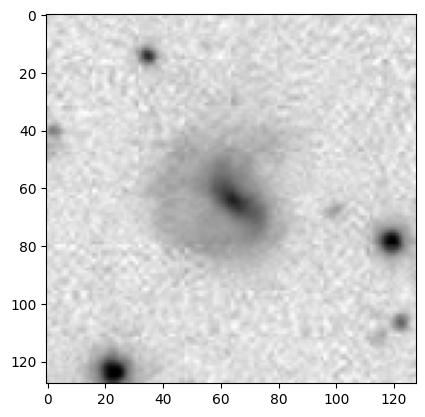

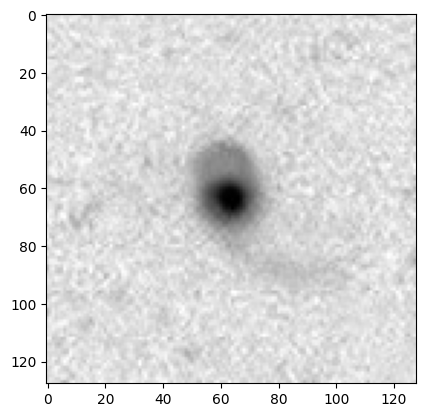

In [4]:
for i in range(5):
    plt.figure()
    plt.imshow(ima[i,:,:,0],cmap='binary')
    

In [5]:
images = torch.tensor(ima)
lab = torch.tensor(lab)


In [6]:
# 1. Fix your image format
# for some reason PyTorch needs the images in shape (N_images, N_colours, N_pixels)
if images.shape == (images.shape[0], images.shape[1], images.shape[2], images.shape[3]):
    images = images.permute(0, 3, 1, 2)  # Now: (17736, 3, 64, 64)

# 2. Normalize
# pixel strengths need to be normalised to make it feasible for the model to learn correctly
if images.max() > 1:
    images = images.float() / (images.shape[1] - 1.0)

# 3. Convert labels if one-hot
# one-hot means that each image has an associated list on length equal to the number of classes, where each value is 0 apart from the class
# that that image falls in (say barred spiral galaxy). For some reason, PyTorch doesn't like this, so we have to instead pass a list of length N_images 
# with the number highlights which class the image is categorised in
if len(lab.shape) > 1:
    labels = torch.argmax(lab, dim=1)

# Split the data into train and test

In [7]:
# Create dataset and dataloader
# Define your percentages
train_pct = 0.70
val_pct = 0.15
test_pct = 0.15

dataset = TensorDataset(images, labels)

# Calculate sizes as integers
train_size = int(train_pct * len(images))
val_size = int(val_pct * len(images))
test_size = len(images) - train_size - val_size  # Remainder goes to test to ensure sum matches

train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size]) # can't just put 0.8 and 0.2 here as PyTorch interprets integers. Thus, it has to be the length that 80% of the sample would correspond to

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [8]:
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Val size: {len(val_dataset)}")

Train size: 12415
Test size: 2661
Val size: 2660


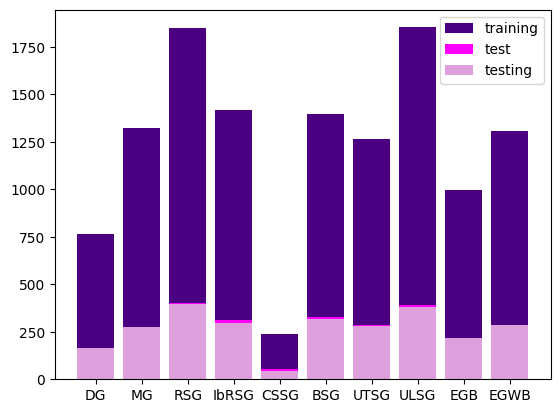

In [9]:
# Get the indices from the splits
train_indices = train_dataset.indices
test_indices = test_dataset.indices
val_indices = val_dataset.indices

# Get the actual split labels
train_labels = lab[train_indices]
test_labels = lab[test_indices]
val_labels = lab[val_indices]

#  check that the categories are balanced in the training and test set
categories = ['DG', 'MG', 'RSG', 'IbRSG', 'CSSG', 'BSG', 'UTSG', 'ULSG', 'EGB', 'EGWB']
plt.bar(categories, torch.sum(train_labels, dim=0), label='training', color = 'indigo');
plt.bar(categories, torch.sum(test_labels, dim=0), label='test', color = 'magenta');
plt.bar(categories, torch.sum(val_labels,dim=0), label='testing', color = 'plum');
plt.legend()

# Lastly, before training we will rotate some of the images so that the model learns ``galaxy'' features rather than pixel features

Next what we will do is allow the training data to rotate. This will enable the model to learn shapes instead of pixel locations.

Because galaxies have no "up" or "down" in space, giving the model a full $180^\circ$ of random rotation is one of the most effective ways to force it to learn shapes instead of pixel locations.

In [10]:
# Training: Rotation + Flips
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # 50% chance of horizontal flipping
    transforms.RandomVerticalFlip(p=0.5), # 50% chance of vertical flipping
    transforms.RandomRotation(degrees=180), # every single image gets a unique, random angle assigned to it every time it's pulled from the dataset between -180 and 180 degrees
])

class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.dataset)

In [11]:
# Wrap the split datasets
train_dataset_augmented = AugmentedDataset(train_dataset, transform=train_transforms)
test_dataset_augmented = AugmentedDataset(test_dataset, transform=None)
val_dataset_augmented = AugmentedDataset(val_dataset, transform=None)

# Update your Loaders
train_loader = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_augmented, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset_augmented, batch_size=64, shuffle=False)


# build a CNN model

In [12]:
# Define relevant variables for the ML task
n_classes = 10
learning_rate = 0.001
num_epochs = 50

In [13]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GalaxyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(GalaxyCNN, self).__init__()
        
        # Block 1: 128x128 -> 64x64
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Block 2: 64x64 -> 32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Block 3: 32x32 -> 16x16
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Block 4: 16x16 -> 8x8
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Block 5: 8x8 -> 4x4 (The "Detail" Layer)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        
        # We define one pool and reuse it
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Global Average Pooling (4x4 -> 1x1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Dropout: 40% chance to drop a neuron during training
        self.dropout = nn.Dropout(0.4)
        
        # Final Classifier
        self.fc = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # Block 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        # Block 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        # Block 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        # Block 4
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        # Block 5
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        
        # Flattening sequence
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [15]:
# compute the weights to let the model know to ``care more'' about under represented classes
# You tell the Loss Function to "care more" about the smaller classes. If a class has 1/10th the images, you make its mistakes 10x more expensive.
weights = (lab.shape[0])/(lab.shape[1] * torch.sum(lab, dim=0))
weights = weights.to(device)

model = GalaxyCNN(num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss(weight = weights)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [16]:
# 6. Training loop
patience = 5
trigger_times = 0
best_test_loss = float('inf')

for epoch in tqdm.tqdm_notebook(range(num_epochs)): # an epoch is one full pass through your entire dataset. this loop ensures your model sees your data multiple times
    model.train() # this sets the PyTorch model into ``training mode''
    correct = 0 # counter for the number of correct classifications
    total = 0 # counter for total images compared

    # Wrap the loader in tqdm for a progress bar
    # train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]") # this creates a visual training bar to see the progress
    
    for batch_images, batch_labels in train_loader: # loop over the training data, and get the images and labels, but batched into small batch quantity sizes
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device) # this moves data from the computer's RAM to GPU (if available)
        
        outputs = model(batch_images) # the forward pass: the images go through the NN layers and spits out its best guess
        loss = criterion(outputs, batch_labels) # model calculates loss (how good the guesses are) in this case using CrossEntropy (good for classification)

        _, predicted = torch.max(outputs.data, 1) # The model outputs 10 numbers per image (probability for each one). torch.max finds the highest number (the most likely class) and gives us its index
        total += batch_labels.size(0) # Keeps track of how many images we have checked in total
        correct += (predicted == batch_labels).sum().item() # compares the predicted class from the model to the actual class. If correct, adds 1
        
        optimizer.zero_grad() # clear the memory of gradients calculated so that the model doesn't get confused with old data when estimating for new batch
        loss.backward() # PyTorch travels back through the network to calculate how much each weight contributed to the loss
        optimizer.step() # optimiser (Adam in this case) updates the weights in the direction that reduces the loss
        
        # Optional: Update the progress bar with the current loss
        # train_loader.set_postfix(loss=loss.item()) # This updates the text next to your progress bar so you can watch the loss drop in real time
    
    # calculate total accuracy 
    accuracy = 100 * correct / total # Calculates the final percentage of images the model identified correctly
    print(f'Done! Final Accuracy for Training: {accuracy:.2f}%')
    
    # Validation
    model.eval() # sets the model to evaluation mode (freezes Batch Normalization and turns off Dropout so the model provides a consistent, deterministic prediction)
    correct = 0 # counter for the number of correct classifications
    total = 0 # counter for total images compared
    test_loss = 0.0
    
    # Wrap validation in tqdm too
    # val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]") # this creates a visual training bar to see the progress
    
    with torch.no_grad(): # this tells PyTorch to not track gradients. Since we are not training we don't need to save this for backward pass
        for batch_images, batch_labels in test_loader: # loop through the validation data and take batches
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device) # allow the computer to use GPUs if available
            
            outputs = model(batch_images) # the forward pass: the images go through the NN layers and spits out its best guess
            
            # 3. Calculate loss for this batch
            loss = criterion(outputs, batch_labels)
            test_loss += loss.item() # Add it up
            
            _, predicted = torch.max(outputs.data, 1) # The model outputs 10 numbers per image (probability for each one). torch.max finds the highest number (the most likely class) and gives us its index
            total += batch_labels.size(0) # Keeps track of how many images we have checked in total
            correct += (predicted == batch_labels).sum().item() # compares the predicted class from the model to the actual class. If correct, adds 1

    # Calculate averages for the whole epoch
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = 100 * correct / total

    # calculate total accuracy 
    accuracy = 100 * correct / total # Calculates the final percentage of images the model identified correctly
    print(f'Done! Final Accuracy for Validation: {accuracy:.2f}%')

    # EARLY STOPPING LOGIC
    if avg_test_loss < best_test_loss:
        print(f"Validation loss improved from {best_test_loss:.4f} to {avg_test_loss:.4f}. Saving model...")
        best_test_loss = avg_test_loss
        trigger_times = 0
        # Save the "best" version of the model
        torch.save(model.state_dict(), 'best_galaxy_model.pth')
    else:
        trigger_times += 1
        print(f"No improvement. EarlyStopping counter: {trigger_times} out of {patience}")
        
        if trigger_times >= patience:
            print("--- Early stopping triggered! Training finished. ---")
            break

    

/var/folders/sf/jx8b7_7d0z72q4z5n56gmm4c0000gp/T/ipykernel_61645/2967369338.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)): # an epoch is one full pass through your entire dataset. this loop ensures your model sees your data multiple times


  0%|          | 0/50 [00:00<?, ?it/s]

Done! Final Accuracy for Training: 34.36%
Done! Final Accuracy for Validation: 22.70%
Validation loss improved from inf to 1.9809. Saving model...
Done! Final Accuracy for Training: 44.31%
Done! Final Accuracy for Validation: 34.91%
Validation loss improved from 1.9809 to 1.7626. Saving model...
Done! Final Accuracy for Training: 52.19%
Done! Final Accuracy for Validation: 56.22%
Validation loss improved from 1.7626 to 1.2769. Saving model...
Done! Final Accuracy for Training: 58.99%
Done! Final Accuracy for Validation: 52.31%
Validation loss improved from 1.2769 to 1.2437. Saving model...
Done! Final Accuracy for Training: 61.53%
Done! Final Accuracy for Validation: 57.38%
No improvement. EarlyStopping counter: 1 out of 5
Done! Final Accuracy for Training: 64.19%
Done! Final Accuracy for Validation: 65.13%
Validation loss improved from 1.2437 to 0.9903. Saving model...
Done! Final Accuracy for Training: 66.33%
Done! Final Accuracy for Validation: 55.47%
No improvement. EarlyStopping c

# fine-tuning stage

In [17]:
# Create the model architecture
model = GalaxyCNN(num_classes=n_classes).to(device)
# Load the weights from your last 76% run
model.load_state_dict(torch.load('best_galaxy_model.pth'))

# Lower the learning rate for the final stretch. Before we had 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


In [19]:
# 6. Training loop
patience = 5
trigger_times = 0

for epoch in tqdm.tqdm_notebook(range(num_epochs)): # an epoch is one full pass through your entire dataset. this loop ensures your model sees your data multiple times
    model.train() # this sets the PyTorch model into ``training mode''
    correct = 0 # counter for the number of correct classifications
    total = 0 # counter for total images compared

    # Wrap the loader in tqdm for a progress bar
    # train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]") # this creates a visual training bar to see the progress
    
    for batch_images, batch_labels in train_loader: # loop over the training data, and get the images and labels, but batched into small batch quantity sizes
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device) # this moves data from the computer's RAM to GPU (if available)
        
        outputs = model(batch_images) # the forward pass: the images go through the NN layers and spits out its best guess
        loss = criterion(outputs, batch_labels) # model calculates loss (how good the guesses are) in this case using CrossEntropy (good for classification)

        _, predicted = torch.max(outputs.data, 1) # The model outputs 10 numbers per image (probability for each one). torch.max finds the highest number (the most likely class) and gives us its index
        total += batch_labels.size(0) # Keeps track of how many images we have checked in total
        correct += (predicted == batch_labels).sum().item() # compares the predicted class from the model to the actual class. If correct, adds 1
        
        optimizer.zero_grad() # clear the memory of gradients calculated so that the model doesn't get confused with old data when estimating for new batch
        loss.backward() # PyTorch travels back through the network to calculate how much each weight contributed to the loss
        optimizer.step() # optimiser (Adam in this case) updates the weights in the direction that reduces the loss
        
        # Optional: Update the progress bar with the current loss
        # train_loader.set_postfix(loss=loss.item()) # This updates the text next to your progress bar so you can watch the loss drop in real time
    
    # calculate total accuracy 
    accuracy = 100 * correct / total # Calculates the final percentage of images the model identified correctly
    print(f'Done! Final Accuracy for Training: {accuracy:.2f}%')
    
    # Validation
    model.eval() # sets the model to evaluation mode (freezes Batch Normalization and turns off Dropout so the model provides a consistent, deterministic prediction)
    correct = 0 # counter for the number of correct classifications
    total = 0 # counter for total images compared
    test_loss = 0.0
    
    # Wrap validation in tqdm too
    # val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]") # this creates a visual training bar to see the progress
    
    with torch.no_grad(): # this tells PyTorch to not track gradients. Since we are not training we don't need to save this for backward pass
        for batch_images, batch_labels in test_loader: # loop through the validation data and take batches
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device) # allow the computer to use GPUs if available
            
            outputs = model(batch_images) # the forward pass: the images go through the NN layers and spits out its best guess
            
            # 3. Calculate loss for this batch
            loss = criterion(outputs, batch_labels)
            test_loss += loss.item() # Add it up
            
            _, predicted = torch.max(outputs.data, 1) # The model outputs 10 numbers per image (probability for each one). torch.max finds the highest number (the most likely class) and gives us its index
            total += batch_labels.size(0) # Keeps track of how many images we have checked in total
            correct += (predicted == batch_labels).sum().item() # compares the predicted class from the model to the actual class. If correct, adds 1

    # Calculate averages for the whole epoch
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = 100 * correct / total

    # calculate total accuracy 
    accuracy = 100 * correct / total # Calculates the final percentage of images the model identified correctly
    print(f'Done! Final Accuracy for Validation: {accuracy:.2f}%')

    # EARLY STOPPING LOGIC
    if avg_test_loss < best_test_loss:
        print(f"Validation loss improved from {best_test_loss:.4f} to {avg_test_loss:.4f}. Saving model...")
        best_test_loss = avg_test_loss
        trigger_times = 0
        # Save the "best" version of the model
        torch.save(model.state_dict(), 'best_galaxy_model.pth')
    else:
        trigger_times += 1
        print(f"No improvement. EarlyStopping counter: {trigger_times} out of {patience}")
        
        if trigger_times >= patience:
            print("--- Early stopping triggered! Training finished. ---")
            break

    

/var/folders/sf/jx8b7_7d0z72q4z5n56gmm4c0000gp/T/ipykernel_61645/1991631008.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs)): # an epoch is one full pass through your entire dataset. this loop ensures your model sees your data multiple times


  0%|          | 0/50 [00:00<?, ?it/s]

Done! Final Accuracy for Training: 76.88%
Done! Final Accuracy for Validation: 73.09%
Validation loss improved from 0.7044 to 0.7036. Saving model...
Done! Final Accuracy for Training: 77.14%
Done! Final Accuracy for Validation: 74.18%
Validation loss improved from 0.7036 to 0.6687. Saving model...
Done! Final Accuracy for Training: 77.06%
Done! Final Accuracy for Validation: 72.34%
No improvement. EarlyStopping counter: 1 out of 5
Done! Final Accuracy for Training: 77.51%
Done! Final Accuracy for Validation: 77.49%
Validation loss improved from 0.6687 to 0.6467. Saving model...
Done! Final Accuracy for Training: 77.57%
Done! Final Accuracy for Validation: 77.60%
Validation loss improved from 0.6467 to 0.6399. Saving model...
Done! Final Accuracy for Training: 77.99%
Done! Final Accuracy for Validation: 74.48%
No improvement. EarlyStopping counter: 1 out of 5
Done! Final Accuracy for Training: 78.18%
Done! Final Accuracy for Validation: 78.62%
Validation loss improved from 0.6399 to 0.

# now let's assess the model does on validation data!

In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
# get the total predictions vs actual values to calculate the confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)


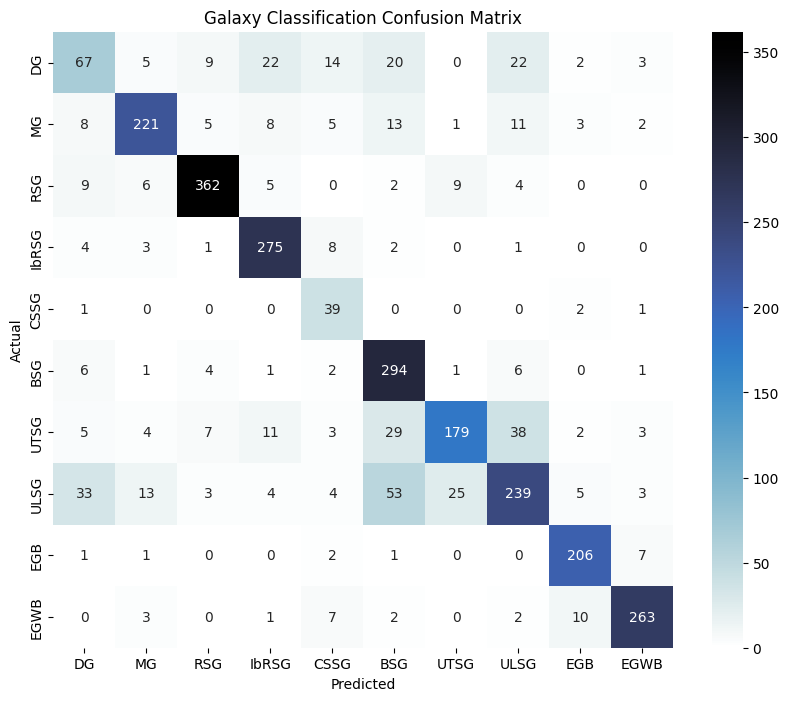

In [22]:
import seaborn as sns
import cmasher

plt.figure(figsize=(10, 8))
# plt.imshow(cm, cmap='Blues',)
sns.heatmap(cm, annot=True, fmt='d', cmap= cmasher.arctic_r, 
                xticklabels=categories, yticklabels=categories)
# plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Galaxy Classification Confusion Matrix')
plt.show()

In [23]:
per = np.diag(cm)/torch.sum(val_labels,dim=0)
formatted_per = [f"{val:.2%}" for val in per]
print(f"Final accuracy percentages: {formatted_per}")

Final accuracy percentages: ['40.85%', '79.78%', '91.18%', '93.54%', '90.70%', '93.04%', '63.70%', '62.57%', '94.50%', '91.32%']
